# Arbeiten mit Geo Vektordaten

- Shapely
- Fiona
- Rasterio

## Shapely
[Shapely](https://github.com/Toblerity/Shapely) kann zur Manipulation und Analyse von geometriesche Vektordaten verwendet werden. Shapley basiert auf C++-Biblothek [GEOS](https://trac.osgeo.org/geos/), der Standardbibiothek für das Arbeiten mit geometrischen Vektordaten. So wird GEOS beispielsweise von PostGIS verwendet, welche die Räumliche Erweiterung für die PostgreSQL-Datenbank ist. Shapely, bietet unteranderem Funktionalitäten wie [buffer](http://toblerity.org/shapely/manual.html?#object.buffer),[union](http://toblerity.org/shapely/manual.html?#object.union), [intersection](http://toblerity.org/shapely/manual.html?#object.intersection), [centroid](http://toblerity.org/shapely/manual.html?#object.centroid),[convex hull](http://toblerity.org/shapely/manual.html?#object.convex_hull) und einiges mehr an.

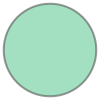

In [95]:
from shapely.geometry import Point
Point(0.0, 0.0).buffer(10.0)

### Farbkodierung in Shapely

- Geometrien können im juypter notebook direkt visualisiert werden.
- Geometrien sind farbkodiert (Jupyter konform).
  - Grün: Valide Geometrien
  - Rot: Invalide Geometrien


Beispiel für eine invalide Geometrie (invalid self-touching LinearRing)

Ring Self-intersection at or near point 1 1


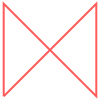

In [96]:
from shapely.geometry.polygon import LinearRing
LinearRing([(0, 0), (0, 2), (1, 1), (2, 2), (2, 0), (1, 1), (0, 0)])

### Beispiele für einfache Funktionsaufrufe

In [97]:
Point(0.0, 0.0).buffer(10.0).area

313.6548490545939

### Verwendung von wkt und json für die Text-Repräsentation einer Geometrie

In [98]:
from shapely.wkt import dumps, loads
dumps(loads('POINT (0 0)'))

'POINT (0.0000000000000000 0.0000000000000000)'

In [99]:
import json
from shapely.geometry import shape,mapping
s=shape(json.loads('{"type": "Point", "coordinates": [0.0, 0.0]}'))

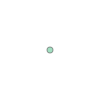

In [100]:
s

In [101]:
print(json.dumps(mapping(s)))

{"type": "Point", "coordinates": [0.0, 0.0]}


### Beispiel: Differenzbildung zweier Geometrien mittels der Shapely Funktion [difference](http://toblerity.org/shapely/manual.html#object.difference)

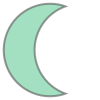

In [102]:
a = Point(1, 1).buffer(1.5)
b = Point(2, 1).buffer(1.5)
a.difference(b)

## Interaktivität im Jupyter Notebook

Benötigt [IPython widgets](https://github.com/jupyter-widgets/ipywidgets). Die Funktion ```interactive``` liefert interaktive "Widgets" für die Funktionsparameter

### Einfacher Funktionstest der benötigten Komponenten

In [103]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


In [104]:
def f(x):
    return x

In [105]:
interact(f, x=10);

### Einfacher Test mit Shapely

In [106]:
def buffer(geometry,radius):
    return geometry.buffer(radius)

interact(buffer, geometry=fixed(Point(0,0)), radius=50)

<function __main__.buffer>

## Fiona
[Fiona](https://github.com/Toblerity/Fiona) ist eine Python Biblothek für das Lesen und Schreiben von Vektor Geodaten Formaten. Dafür wird die C Biblothek OGR aus [http://www.gdal.org/](http://www.gdal.org/) verwendet. OGR unterstützt [sehr viele Datenformate](http://www.gdal.org/ogr_formats.html) zur Konvertierung von Geodaten. So wird OGR beispielsweise von Mapnik verwendet, womit beispielsweise die OpenStreetMap-Karten gerendert werden.

Warum GEOS und OGR nicht direkt verwenden? GEOS, bietet keine direkte Python-Anbindung an. Um GEOS zu verwenden muss C++-Code geschrieben werden. Die GEOS-Community empfiehlt die Verwednung von Shapely in Zusammenhang mit Python.
OGR bietet eine Python-Anbindung, allerdings verhält diese sich nicht wirklich Python-mäßig, und ist teilweise fehleranfällig.

## Empfehlung
Fiona für die Ein- und Ausgabe und Shapley für die Manipulation und Analyse von Geodaten verwenden

## Beliebige Datenformate in Geodaten-Formate verwandeln
Am Beispiel einer einfachen [CSV-Datei](https://de.wikipedia.org/wiki/CSV_%28Dateiformat%29) soll gezeigt werden, wie diese in eine Shape-Datei konvertiert werden kann.

```
name,lat,lon
Hamburg,53.565278, 10.001389
Rostock,54.083333, 12.133333
Osnabrück,52.283333, 8.05
```

Zum Laden der CSV-Datei wird der [Python CSV reader](https://docs.python.org/3/library/csv.html) verwendet. 

In [107]:
import csv
with open('staedte.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        print(row['name'],row['lat'],row['lon'])

Hamburg 53.565278  10.001389
Rostock 54.083333  12.133333
Osnabrück 52.283333  8.05


Als nächstes müssen aus den Koordinaten Punkte gemacht werden. Hierzu wird die [Shapely Repräsentation eines Punktes](http://toblerity.org/shapely/manual.html#points) verwendet. Welche mittels ```shapely.geometry import Point``` importiert wird. Der Punkt bekommt die Koordinaten in der Reihenfolge ```longitude```,```latitude``` übergeben! Da CSV implizit Text und keine Zahlen repräsentiert, wird die Python [float()](https://docs.python.org/3/library/functions.html?#float) Funktion zur Konvertierung verwendet.

In [108]:
import csv
from shapely.geometry import Point, MultiPoint
with open('staedte.csv') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        point=Point(float(row['lon']), float(row['lat']))

### Die Inhalte der CSV-Datei als ESRI Shapefile mittels Fiona speichern.

In [109]:
import csv
from shapely.geometry import Point, mapping
from fiona import collection

schema = { 'geometry': 'Point', 'properties': { 'name': 'str' } }
with collection(
    "staedte.shp", "w", "ESRI Shapefile", schema) as output:
    with open('staedte.csv') as f:
        reader = csv.DictReader(f)
        for row in reader:
            point = Point(float(row['lon']), float(row['lat']))
            output.write({
                'properties': {
                    'name': row['name']
                },
                'geometry': mapping(point)
            })

### Einlesen des erstellten ESRI Shapefiles mittels fiona.

In [110]:
import fiona
c = fiona.open('staedte.shp', 'r')

### Collection indexing
Auf Features einer Collection können über einen Index zugegriffen werden.

In [111]:
import pprint
pprint.pprint(c[1])

{'geometry': {'coordinates': (12.133333, 54.083333), 'type': 'Point'},
 'id': '1',
 'properties': OrderedDict([('name', 'Rostock')]),
 'type': 'Feature'}


### Visualisierung der Punkte aus dem ESRI Shapefile.

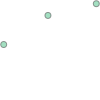

In [112]:
from shapely.geometry import mapping, shape
points=None
for feature in c:
    if not points:
        points = shape(feature['geometry'])
    points= points.union(shape(feature['geometry']))
points

# Einführung in das Arbeiten mit Rasterdaten mittels [rasterio](https://github.com/mapbox/rasterio)

## Überblick über den Datensatz verschaffen

In [113]:
import rasterio
from rasterio.plot import show

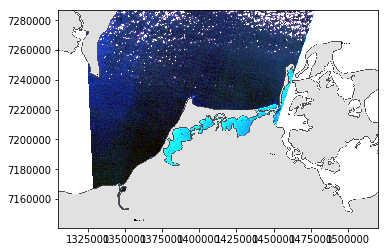

In [114]:
with rasterio.open("/tmp/bsh/Meereis/SatTiffs/ek_edit160106_Sentinel2_vom06012016.tif") as src:
    show((src))

In [115]:
src.meta

{'affine': Affine(46.17483051195663, 0.0, 1305381.878773258,
       0.0, -46.18089141339655, 7286699.396508208),
 'count': 3,
 'crs': CRS({'x_0': 0, 'datum': 'WGS84', 'units': 'm', 'proj': 'merc', 'y_0': 0, 'k': 1, 'lon_0': 0, 'no_defs': True}),
 'driver': 'GTiff',
 'dtype': 'uint8',
 'height': 3162,
 'nodata': None,
 'transform': (1305381.878773258,
  46.17483051195663,
  0.0,
  7286699.396508208,
  0.0,
  -46.18089141339655),
 'width': 4653}

In [116]:
src.crs

CRS({'x_0': 0, 'datum': 'WGS84', 'units': 'm', 'proj': 'merc', 'y_0': 0, 'k': 1, 'lon_0': 0, 'no_defs': True})

## Layout des Datensatzes

Der Datensatz hat 3162 Zeilen und 4653 Spalten

In [117]:
src.shape

(3162, 4653)

Der Datensatz hat 3 Bänder

In [118]:
src.count

3

Alle 3 Bänder beinhalten 8-bit unsigned integers.

In [119]:
src.dtypes

('uint8', 'uint8', 'uint8')

In [120]:
import numpy as np

dest = np.empty((src.count,) + src.shape, dtype='uint8')
dest

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

## Extrahieren von Geometrie-Umrissen (engl. shapes) aus Rasterbilder (Beispiel 2)

In [121]:
import pprint
import rasterio
from rasterio import features
from shapely.geometry import shape

with rasterio.open('/tmp/bsh/Meereis/SatTiffs/ek_edit160106_Sentinel2_vom06012016.tif') as src:
    blue = src.read(3)

mask = blue != 255
shapes = rasterio.features.shapes(blue, mask=mask)

#### Ausgabe als "GeoJSON-ish feature dicts"

In [122]:
pprint.pprint(next(shapes))

({'coordinates': [[(914.0, 0.0),
                   (914.0, 2.0),
                   (916.0, 2.0),
                   (916.0, 1.0),
                   (915.0, 1.0),
                   (915.0, 0.0),
                   (914.0, 0.0)]],
  'type': 'Polygon'},
 153.0)


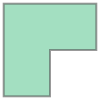

In [123]:
import json
from shapely.geometry import shape
t=shape(json.loads('{"type": "Polygon", "coordinates": [[[914.0, 0.0],[914.0, 2.0],[916.0, 2.0],[916.0, 1.0],[915.0, 1.0],[915.0, 0.0],[914.0, 0.0]]]}'))
t
                   

In [124]:
pprint.pprint(next(shapes))

({'coordinates': [[(915.0, 0.0),
                   (915.0, 1.0),
                   (916.0, 1.0),
                   (916.0, 0.0),
                   (915.0, 0.0)]],
  'type': 'Polygon'},
 147.0)


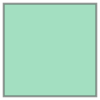

In [125]:
import json
from shapely.geometry import shape
t=shape(json.loads('{"type": "Polygon", "coordinates": [[[915.0, 0.0],[915.0, 1.0],[916.0, 1.0],[916.0, 0.0],[915.0, 0.0]]]}'))
t

## Extrahieren von Geometrie-Umrissen (engl. shapes) aus Rasterbilder (Beispiel 1)

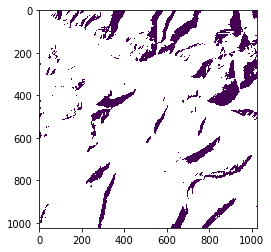

In [126]:
import rasterio
import rasterio.features
from shapely.geometry import shape

with rasterio.open('shade.tif') as src:
    show((src))

In [127]:
with rasterio.open('shade.tif') as src:
    shade, = src.read()

    shade_shapes = sorted(
        (s for s, v in rasterio.features.shapes(shade)),
        key=lambda x: shape(x).area,
        reverse=True)
#Liste
len(shade_shapes)

288

#### Ersten Geometrie-Umriss betrachten

Ring Self-intersection at or near point 630 148


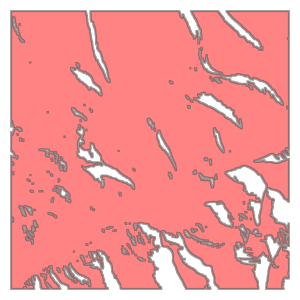

In [128]:
shape(shade_shapes[0])

#### Ausgabe als "GeoJSON-ish feature dicts"

In [129]:
pprint.pprint(shade_shapes[0])

{'coordinates': [[(0.0, 0.0),
                  (0.0, 491.0),
                  (1.0, 491.0),
                  (1.0, 489.0),
                  (2.0, 489.0),
                  (2.0, 488.0),
                  (3.0, 488.0),
                  (3.0, 487.0),
                  (5.0, 487.0),
                  (6.0, 487.0),
                  (6.0, 486.0),
                  (9.0, 486.0),
                  (10.0, 486.0),
                  (10.0, 485.0),
                  (14.0, 485.0),
                  (14.0, 486.0),
                  (15.0, 486.0),
                  (15.0, 487.0),
                  (18.0, 487.0),
                  (18.0, 486.0),
                  (19.0, 486.0),
                  (19.0, 485.0),
                  (20.0, 485.0),
                  (20.0, 481.0),
                  (21.0, 481.0),
                  (21.0, 480.0),
                  (22.0, 480.0),
                  (22.0, 482.0),
                  (23.0, 482.0),
                  (23.0, 484.0),
                  (24.0,

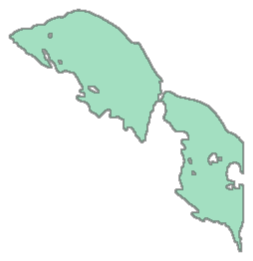

In [130]:
shape(shade_shapes[1])

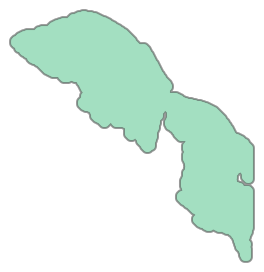

In [131]:
shape(shade_shapes[1]).buffer(5.0)